### HerbaLens Machine Learning Team

### Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/MyDrive/ML HerbaLens/dataset_train_test/train"
val_dir = "/content/drive/MyDrive/ML HerbaLens/dataset_train_test/val"

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(256, 256))

val_generator = val_datagen.flow_from_directory(directory=val_dir,
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  target_size=(256, 256))

Found 2713 images belonging to 36 classes.
Found 698 images belonging to 36 classes.


### Inception V3 Transfer Learning

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inception = InceptionV3(input_shape = (256, 256, 3),
                                  include_top = False,
                                  weights='imagenet')

In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_96[0][0]']              
 ormalization)                  )                                                      

In [ ]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [ ]:
desired_last_output = output_of_last_layer(inception)

last layer output shape:  (None, 14, 14, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


### Build Model

In [ ]:
from tensorflow.keras.models import Model

def create_model(pre_trained_model, desired_last_output):

  x = tf.keras.layers.Conv2D(128, 2, activation='relu')(desired_last_output)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Conv2D(256, 5, activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(36, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  from tensorflow.keras.optimizers import RMSprop

  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Create Model
model = create_model(inception, desired_last_output)

In [ ]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_96[0][0]']              
 ormalization)                  )                                                           

In [ ]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.99):
          self.model.stop_training = True

In [ ]:
hist = model.fit(train_generator, epochs=15, verbose=1, validation_data=val_generator, callbacks=[Callback()])

Epoch 1/15
85/85 [==============================] - 1311s 15s/step - loss: 2.0222 - accuracy: 0.4648 - val_loss: 1.3825 - val_accuracy: 0.5903
Epoch 2/15
85/85 [==============================] - 424s 5s/step - loss: 1.1886 - accuracy: 0.6399 - val_loss: 0.8152 - val_accuracy: 0.7479
Epoch 3/15
85/85 [==============================] - 428s 5s/step - loss: 0.8415 - accuracy: 0.7353 - val_loss: 0.5915 - val_accuracy: 0.7994
Epoch 4/15
85/85 [==============================] - 427s 5s/step - loss: 0.6242 - accuracy: 0.7999 - val_loss: 0.4292 - val_accuracy: 0.8567
Epoch 5/15
85/85 [==============================] - 431s 5s/step - loss: 0.5159 - accuracy: 0.8312 - val_loss: 0.5152 - val_accuracy: 0.8481
Epoch 6/15
85/85 [==============================] - 428s 5s/step - loss: 0.4310 - accuracy: 0.8577 - val_loss: 0.3608 - val_accuracy: 0.8797
Epoch 7/15
85/85 [==============================] - 428s 5s/step - loss: 0.4066 - accuracy: 0.8754 - val_loss: 0.3085 - val_accuracy: 0.9083
Epoch 8/15


### Plot Accuracy and Loss

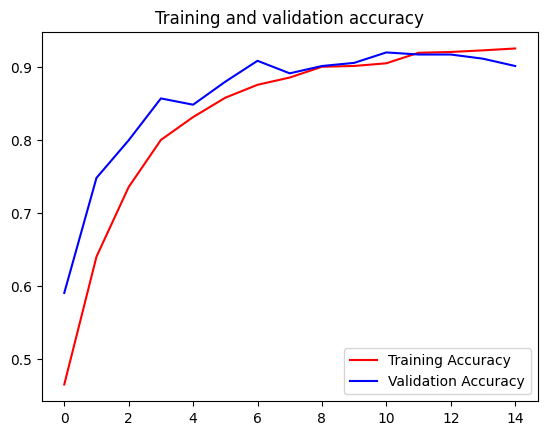

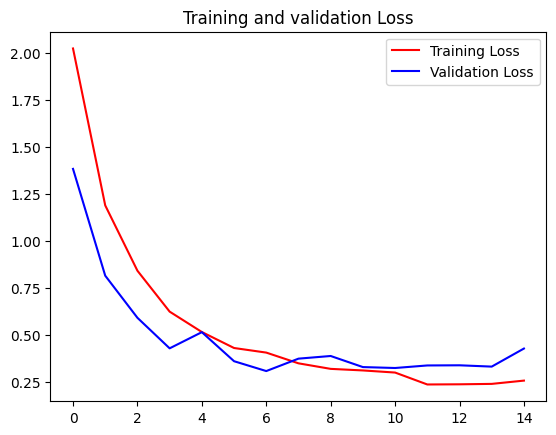

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print('')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

### Testing

In [ ]:
y_pred = model.predict(val_generator)

22/22 [==============================] - 78s 4s/step


In [ ]:
y_pred

array([[2.9605515e-17, 6.2929324e-24, 0.0000000e+00, ..., 6.0932506e-16,
        4.0822703e-32, 4.9049117e-29],
       [1.5785839e-06, 1.2371998e-05, 4.5247759e-07, ..., 3.6886537e-05,
        2.7935911e-08, 1.7668295e-06],
       [1.0236083e-16, 2.8730160e-23, 7.1453661e-13, ..., 1.2717298e-25,
        3.7440207e-22, 5.9442120e-21],
       ...,
       [5.5967581e-01, 3.2970112e-07, 4.4253776e-03, ..., 1.1236713e-05,
        2.9829612e-02, 5.0880026e-06],
       [5.0623110e-09, 3.9692756e-11, 2.9894752e-06, ..., 2.5444946e-09,
        3.0337558e-12, 2.7988745e-09],
       [5.5041671e-15, 3.6539824e-09, 1.3396767e-09, ..., 7.4908299e-15,
        1.2498838e-07, 1.2518018e-09]], dtype=float32)

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([27,  7, 15, 14, 13, 26, 14, 13, 26, 33, 25, 33, 27, 29, 34, 26, 31,
       15,  7, 26, 17, 14, 27,  5, 31, 27,  4, 25, 32,  9, 27, 27,  2, 35,
       26, 27, 12,  9, 34, 27, 14, 27,  4, 26, 27, 21, 27, 26, 27, 26, 17,
        0,  9, 27, 11, 27, 26, 14, 11, 27, 26, 27, 14,  7, 27, 14, 11, 26,
        6, 27, 27, 14, 26,  4, 27, 18,  2, 27, 27,  5, 27, 15, 26, 26, 32,
       20, 29, 21, 27, 20, 27, 20, 25, 26, 31, 26, 26,  7, 14, 13, 11, 13,
       11, 26, 27,  5,  4, 25, 12, 11, 27, 25,  2, 27, 27, 26, 27,  6, 26,
       27, 27, 21, 26,  4,  4,  4, 13, 16,  2, 27, 27, 26, 21, 27,  5, 27,
       16, 33,  9,  3, 27, 33,  1, 27, 11, 27,  5,  6, 28, 26, 14, 27, 15,
       27, 30, 27, 27, 10, 31, 28, 14, 28, 35,  6, 11, 27, 24, 11,  9,  5,
       20,  0, 26,  5, 31, 12, 27, 11, 26, 11, 27, 27, 18, 26, 30,  5, 29,
       12, 27,  5, 19, 13, 27, 35, 31, 27, 27, 27, 26, 28, 26,  8, 34, 28,
       27,  9,  6, 35, 27, 23, 22,  3, 33, 23,  8, 26, 20, 15, 27, 27,  3,
       27, 19, 12, 24, 25

### Save the Model as h5 File

In [ ]:
model.save('/content/drive/MyDrive/ML HerbaLens/model', 'herbal_plants_model.h5')
print("Model saved as 'herbal_plants_model.h5'")

Model saved as 'herbal_plants_model.h5'


### Load Model

In [ ]:
from tensorflow.keras.models import load_model

new_model = load_model('/content/drive/MyDrive/ML HerbaLens/model')

In [ ]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_96[0][0]']              
 ormalization)                  )                                                           

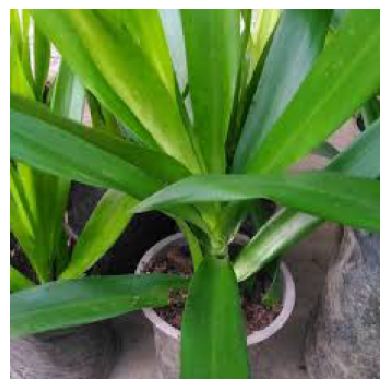

In [ ]:
# Testing new data
image_path = '/content/drive/MyDrive/ML HerbaLens/gambar buat tes/suji_10.jpg'
image = load_img(image_path, target_size=(256, 256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = image / 255.0  # Normalize the image data

# Display the input image
plt.imshow(image[0])
plt.axis('off')
plt.show()

In [ ]:
# Perform inference and get the predicted probabilities
predictions = new_model.predict(image)

plant_names = [
    'Alang-alang', 'Belimbing Wuluh', 'Daun Encok', 'Daun Gedi', 'Daun Jintan',
    'Daun Kari', 'Daun Mint', 'Jahe', 'Jambu Biji', 'Jeruk Lemon', 'Jeruk Nipis',
    'Kelengkeng', 'Kenanga', 'Kencur', 'Ketumbar', 'Krisan / Bunga Seruni',
    'Kumis Kucing', 'Kunyit', 'Lengkuas', 'Lidah Buaya', 'Mengkudu', 'Murbai',
    'Nangka', 'Pacar Air', 'Pandan', 'Patikan Kebo', 'Pir', 'Plum', 'Rosela',
    'Rosemary', 'Serai', 'Sirih', 'Sirsak', 'Srikaya', 'Suji', 'Zaitun'
]

# Get the predicted label index
predicted_label_index = np.argmax(predictions)

# Get the predicted label name
predicted_label = plant_names[predicted_label_index]

# Print the predicted label
print('Predicted Label:', predicted_label)

1/1 [==============================] - 0s 162ms/step
Predicted Label: Suji


### Convert Model to TFLite

In [ ]:
# Select mode of optimization
mode = "balanced"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter
export_dir = '/content/drive/MyDrive/ML HerbaLens/model'
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/drive/MyDrive/ML HerbaLens/model.tflite')
tflite_model_file.write_bytes(tflite_model)

10664616